# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by Andrea Rausa

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [3]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [5]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 10819 / 11441 MB available


In [42]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;

    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel( float* c, float* a, float* b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;  // Idx = Index
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    unsigned int k = j * cols + i; // I'm using linear indexes for going through the matrix
    
    // Pseudocode
    // c[j][i] = a[j][i] + b[j][i]
    
    c[k] = a[k] + b[k];
}

__global__ void multMatVecKernel( float* c, float* a, float* b, int cols){
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    unsigned int k = j * cols + i;
    
    c[j] = a[k] * b[j];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("multMatVecKernel");

<bound method Figure.show of <matplotlib.figure.Figure object at 0x7f75f091f240>>

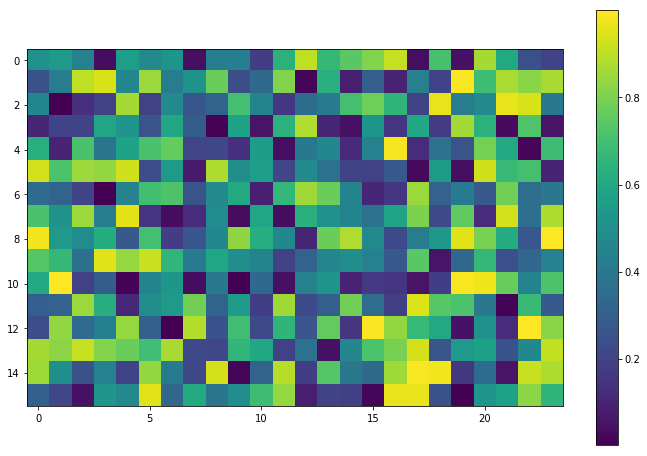

In [43]:
#Size of our test
test_size = (16, 24)  # always try to use different sizes for columns and rows

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size[0]).astype(np.float32)
c = np.empty_like(b)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
fig.show

In [44]:
print(a.shape)
print(b.shape)

(16, 24)
(16,)


In [19]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [20]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [37]:
# a.shape = [rows, columns] => [y,x] I have to transpose it 'cause in the kernel we've done it

domain_size = (a.shape[1], a.shape[0]) # now domain is in [x, y, z]
block_size = (8, 4, 1)
grid_size = (domain_size[0]//block_size[0], domain_size[1]//block_size[1], 1)  # // is integer division and / is real division. we want integers

print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size)) 
print("Domain size is " + str(domain_size))

Block size is (8, 4, 1)
Grid size is (3, 4, 1)
Domain size is (24, 16)


In [38]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block = block_size, grid = grid_size) # I have to pass the exact value of domain_size[1]

In [39]:
#Copy data from device to host
c_g.get(c)

array([[0.30874   , 0.49913433, 0.6674378 , 0.54250693, 1.0944571 ,
        1.4623718 , 1.695982  , 0.3967465 , 1.3457166 , 1.0039402 ,
        0.62689626, 0.54251677, 0.69780916, 0.75504863, 1.3156292 ,
        1.2827667 , 0.38807288, 0.5226969 , 1.0457029 , 0.967114  ,
        1.3252735 , 0.6866703 , 0.4277768 , 0.9055469 ],
       [1.6908553 , 1.0316973 , 1.1771215 , 1.5725267 , 1.6346146 ,
        1.5264046 , 1.1271572 , 1.2982844 , 0.9745383 , 1.7055471 ,
        1.2849618 , 1.3946536 , 0.3043125 , 0.21664564, 1.0300617 ,
        1.5829625 , 0.19856948, 1.27763   , 0.7297137 , 1.558249  ,
        0.6423631 , 1.2178807 , 1.3737068 , 0.34489125],
       [0.8744519 , 1.0831376 , 0.86067   , 1.4566491 , 1.1825082 ,
        0.9837386 , 1.1715047 , 1.0955601 , 0.9456692 , 1.3135803 ,
        1.121515  , 0.8926764 , 0.6437118 , 1.2150737 , 0.51531255,
        1.5356662 , 1.2025416 , 1.1468266 , 1.8324981 , 1.3506353 ,
        0.76561314, 1.2210364 , 1.5203147 , 1.6124957 ],
       [0.740

In [40]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref))) # Sum of absolute differences

C   =  [[0.30874    0.49913433 0.6674378  0.54250693 1.0944571  1.4623718
  1.695982   0.3967465  1.3457166  1.0039402  0.62689626 0.54251677
  0.69780916 0.75504863 1.3156292  1.2827667  0.38807288 0.5226969
  1.0457029  0.967114   1.3252735  0.6866703  0.4277768  0.9055469 ]
 [1.6908553  1.0316973  1.1771215  1.5725267  1.6346146  1.5264046
  1.1271572  1.2982844  0.9745383  1.7055471  1.2849618  1.3946536
  0.3043125  0.21664564 1.0300617  1.5829625  0.19856948 1.27763
  0.7297137  1.558249   0.6423631  1.2178807  1.3737068  0.34489125]
 [0.8744519  1.0831376  0.86067    1.4566491  1.1825082  0.9837386
  1.1715047  1.0955601  0.9456692  1.3135803  1.121515   0.8926764
  0.6437118  1.2150737  0.51531255 1.5356662  1.2025416  1.1468266
  1.8324981  1.3506353  0.76561314 1.2210364  1.5203147  1.6124957 ]
 [0.74033654 1.117642   1.0881035  1.2066615  0.9752754  1.3908124
  1.2012137  0.96661997 0.82578    0.883382   1.0232668  1.5061595
  0.5917443  0.5885466  1.4399543  0.99780047 0.82

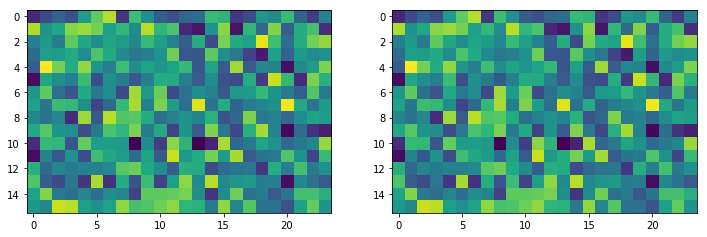

In [41]:
fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(c)
plt.subplot(1, 2, 2)
plt.imshow(c_ref)
